In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.utils import shuffle

from keras.models import Sequential
from keras.layers import InputLayer, LSTM, Dense, Dropout
from keras.optimizers import Adam
from keras.losses import MeanSquaredError
from keras.metrics import RootMeanSquaredError
from keras.constraints import MaxNorm
from keras.callbacks import ModelCheckpoint

In [2]:
filepath = 'C:/Users/ss230/Documents/Study/NSIDC/Edited Data/S_Sea_Ice_Index_Regional_Monthly_Data_G02135_v3.0.xlsx'
Ross_Extent = pd.read_excel(filepath, sheet_name='Ross-Extent-km^2')

In [3]:
import sys
sys.path.append('C:/Users/ss230/Documents/Study/NSIDC/SH/Bi_LSTM_Extent/')
import Function as fp

In [4]:
fp.month_mapping(Ross_Extent)
fp.date_time(Ross_Extent)

,Extent,Date
0,1040455.516,1979-01-01
1,239334.118,1979-02-01
2,557365.154,1979-03-01
3,2054855.924,1979-04-01
4,2973925.625,1979-05-01
...,...,...
533,3137598.938,2023-06-01
534,3201783.453,2023-07-01
535,2973294.266,2023-08-01
536,3354839.711,2023-09-01


In [5]:
scaler = MinMaxScaler()
Ross_Extent['Extent'] = scaler.fit_transform(Ross_Extent['Extent'].values.reshape(-1, 1))

In [6]:
def df_to_X_y(df, window_size):
    df_as_np = df.to_numpy()
    X = []
    y = []
    lead_time = 7
    for i in range(len(df_as_np) - window_size - lead_time + 1):
        window_data = df_as_np[i:i+window_size]
        row = [[a] for a in window_data]
        X.append(row)
        label = df_as_np[i+window_size+lead_time-1]
        y.append(label)
    return np.array(X), np.array(y)

In [7]:
extent = Ross_Extent['Extent']
W_S=12
X,y = df_to_X_y(extent, W_S)
X.shape, y.shape

((520, 12, 1), (520,))

In [8]:
X_train, y_train = X[:420], y[:420]
X_val, y_val = X[420:472], y[420:472]
X_test, y_test = X[472:], y[472:]

In [9]:
model = Sequential()
model.add(InputLayer((W_S, 1)))
model.add(LSTM(128, activation='relu', kernel_constraint=MaxNorm(1.0), return_sequences=True))
model.add(Dropout(0.5))
model.add(LSTM(64, activation='relu', kernel_constraint=MaxNorm(1.0), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(32, activation='relu', kernel_constraint=MaxNorm(1.0)))
model.add(Dense(1, activation='linear'))

cp = ModelCheckpoint('Ross_model_LT7/', save_best_only=True)
model.compile(loss=MeanSquaredError(), optimizer=Adam(0.0001), metrics=[RootMeanSquaredError()])

In [10]:
import time

stime = time.time()
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=50, batch_size=8, callbacks=[cp])
etime = time.time()

Epoch 1/50
53/53 [==============================] - 17s 213ms/step - loss: 0.3678 - root_mean_squared_error: 0.6065 - val_loss: 0.2794 - val_root_mean_squared_error: 0.5286
Epoch 2/50
53/53 [==============================] - 10s 189ms/step - loss: 0.1701 - root_mean_squared_error: 0.4125 - val_loss: 0.0922 - val_root_mean_squared_error: 0.3036
Epoch 3/50
53/53 [==============================] - 10s 185ms/step - loss: 0.0735 - root_mean_squared_error: 0.2710 - val_loss: 0.0828 - val_root_mean_squared_error: 0.2878
Epoch 4/50
53/53 [==============================] - 10s 195ms/step - loss: 0.0701 - root_mean_squared_error: 0.2647 - val_loss: 0.0770 - val_root_mean_squared_error: 0.2775
Epoch 5/50
53/53 [==============================] - 10s 190ms/step - loss: 0.0632 - root_mean_squared_error: 0.2513 - val_loss: 0.0710 - val_root_mean_squared_error: 0.2665
Epoch 6/50
53/53 [==============================] - 10s 186ms/step - loss: 0.0588 - root_mean_squared_error: 0.2424 - val_loss: 0.0639 

53/53 [==============================] - 11s 206ms/step - loss: 0.0123 - root_mean_squared_error: 0.1108 - val_loss: 0.0131 - val_root_mean_squared_error: 0.1145
Epoch 30/50
53/53 [==============================] - 10s 199ms/step - loss: 0.0122 - root_mean_squared_error: 0.1106 - val_loss: 0.0122 - val_root_mean_squared_error: 0.1105
Epoch 31/50
53/53 [==============================] - 2s 33ms/step - loss: 0.0128 - root_mean_squared_error: 0.1132 - val_loss: 0.0129 - val_root_mean_squared_error: 0.1138
Epoch 32/50
53/53 [==============================] - 2s 33ms/step - loss: 0.0118 - root_mean_squared_error: 0.1087 - val_loss: 0.0145 - val_root_mean_squared_error: 0.1206
Epoch 33/50
53/53 [==============================] - 10s 190ms/step - loss: 0.0126 - root_mean_squared_error: 0.1121 - val_loss: 0.0119 - val_root_mean_squared_error: 0.1090
Epoch 34/50
53/53 [==============================] - 10s 201ms/step - loss: 0.0129 - root_mean_squared_error: 0.1136 - val_loss: 0.0117 - val_root

In [11]:
time = (etime - stime)/60
print(f'{time} minutes')

5.56223414738973 minutes


In [12]:
loss = history.history['loss']
epochs = list(range(1, len(loss) + 1))

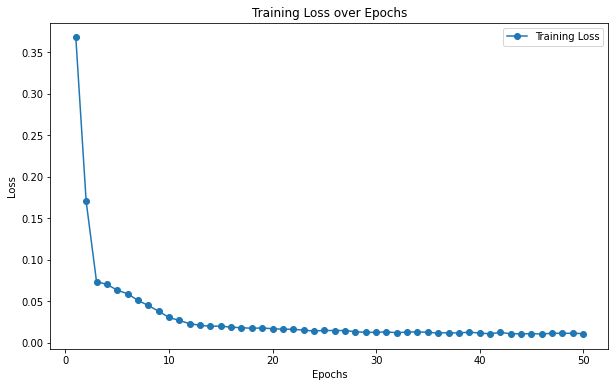

In [13]:
plt.figure(figsize=(10, 6))
plt.plot(epochs, loss, label='Training Loss', marker='o', linestyle='-')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss over Epochs')
plt.legend()
plt.show()

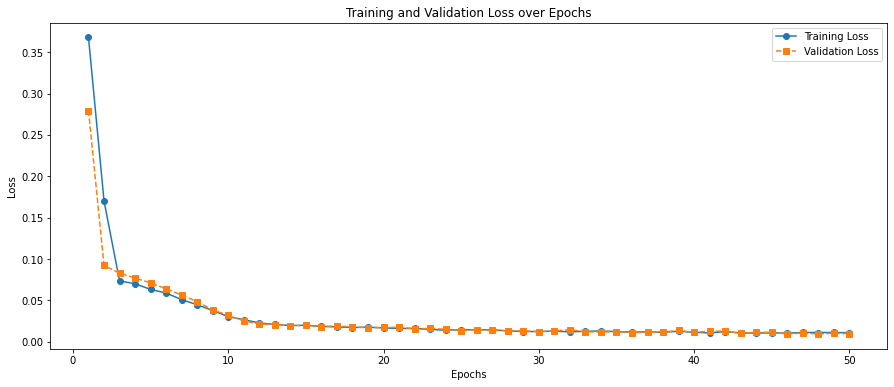

In [14]:
training_loss = history.history['loss']
validation_loss = history.history['val_loss']
epochs = range(1, len(training_loss) + 1)

plt.figure(figsize=(15,6))
plt.plot(epochs, training_loss, label='Training Loss', marker='o', linestyle='-')
plt.plot(epochs, validation_loss, label='Validation Loss', marker='s', linestyle='--')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss over Epochs')
plt.legend()
plt.show()

In [15]:
from tensorflow.keras.models import load_model
model1 = load_model('Ross_model_LT7/')

In [16]:
test_predictions = model1.predict(X_test)

2/2 [==============================] - 1s 10ms/step


In [17]:
mse = mean_squared_error(y_test, test_predictions)
print('RMSE :', np.sqrt(mse))

mae = mean_absolute_error(y_test, test_predictions)
print('MAE :', mae)

RMSE : 0.10278510557305907
MAE : 0.08843425908484541


In [18]:
test_predictions = scaler.inverse_transform(test_predictions)
test_original = scaler.inverse_transform(y_test.reshape(-1,1))

In [19]:
train_results = pd.DataFrame(data={'Train Predictions': test_predictions.flatten(), 'Actual Extent': test_original.flatten()})
train_results

,Train Predictions,Actual Extent
0,2.923792e+06,3499167.351
1,2.064408e+06,2715890.297
2,1.255231e+06,1053272.694
3,6.572081e+05,368862.123
4,5.219912e+05,979418.298
5,1.489671e+06,2086269.569
6,2.459101e+06,2852731.016
7,3.022890e+06,3452823.613
8,3.355749e+06,3846843.974
9,3.617125e+06,4005222.451


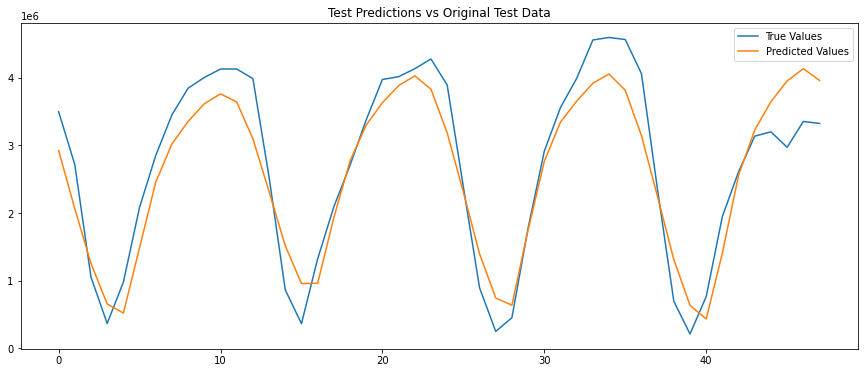

In [20]:
plt.figure(figsize=(15,6))
plt.plot(test_original, label='True Values')
plt.plot(test_predictions, label='Predicted Values')
plt.title('Test Predictions vs Original Test Data')
plt.legend()
plt.show()

In [21]:
predictions = model1.predict(X)

17/17 [==============================] - 0s 14ms/step


In [22]:
predictions = scaler.inverse_transform(predictions)
Original = scaler.inverse_transform(y.reshape(-1,1))

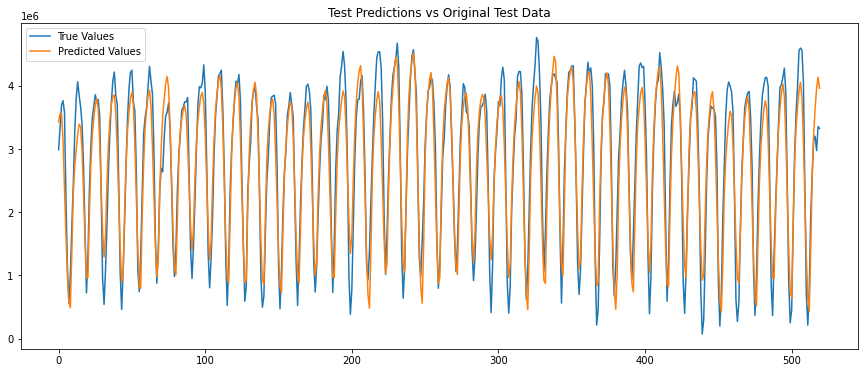

In [23]:
plt.figure(figsize=(15,6))
plt.plot(Original, label='True Values')
plt.plot(predictions, label='Predicted Values')
plt.title('Test Predictions vs Original Test Data')
plt.legend()
plt.show()